## PySMuRF Setup

PySMuRF is the client side control.  It communicates with the server via EPICS channel access (CA).  First we start the server and do imports

In [1]:
import pysmurf.client
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import epics
import os

%matplotlib inline

Next we'll define the EPICS server prefix and experiment configuration file

In [2]:
epics_prefix = "smurf_server_s2"
config_file  = "/usr/local/src/pysmurf/cfg_files/stanford/experiment_fp31_cc03-02_lbOnlyBay0.cfg"
S = pysmurf.client.SmurfControl(epics_root=epics_prefix, cfg_file=config_file, setup=False, make_logfile=True)

Next we run a setup command.  This will initialize the FPGA and load the configuration defined in config_file.

In [3]:
S.setup()

False

### Acquiring data from the digitzers

Let's look at the ADC data.  We'll see the LO and it's image:


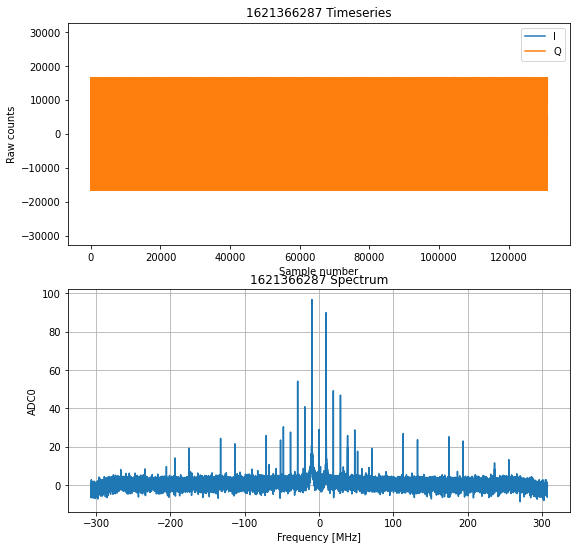

In [4]:
adc_data = S.read_adc_data(data_length=2**16, band=0, make_plot=True, show_plot=True)

### Null the LO
Next let's null the LO with the RTM DACs


In [5]:
## Minimizaiton IQ cal
import epics
from scipy.optimize import minimize
import time

lo_offset = -9.6

def getResp(band, channel):
    S.set_eta_mag_scaled_channel(band, channel, 1)
    S.set_eta_phase_degree_channel(band, channel, 0)
    resp = S.get_frequency_error_mhz(band, channel)
    S.set_eta_phase_degree_channel(band, channel, 90)
    resp = resp + 1j*S.get_frequency_error_mhz(band, channel)
    return resp


def updateCal(x):
    S.set_rtm_slow_dac_volt(1, x[0])
    S.set_rtm_slow_dac_volt(2, x[1])
    time.sleep(0.01)
    return np.abs(getResp(0, dac_cal_ch))**2


S.set_cpld_reset(0)

S.set_rtm_slow_dac_enable(1, 2)
S.set_rtm_slow_dac_enable(2, 2)

# process all channels (even with no amplitude)
epics.caput(epics_prefix + ':AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:highCurrentMode', 1)

# which channel to null
freqs = epics.caget(epics_prefix+':AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:toneFrequencyOffsetMHz')
dac_cal_ch = np.argmin(np.abs(freqs + lo_offset))

S.set_center_frequency_mhz_channel(0, dac_cal_ch, 0)
S.set_amplitude_scale_channel(0, dac_cal_ch, 0)
S.set_feedback_enable_channel(0, dac_cal_ch, 0)

 
x0 = (0.6, 3.4)
bnds = ((-5, 5), (-5, 5))
res = minimize(updateCal, x0, method='Powell', bounds=bnds, tol=1e-7)
print(f'IQ DAC cal is: ' + str(res.x))
updateCal(res.x)

IQ DAC cal is: [1.12385203 2.63931677]


6.172352459543617e-07

In [6]:
np.abs(getResp(0, dac_cal_ch))**2

6.555909044436702e-07

In [7]:
S.set_amplitude_scale_channel(0, 0, 0)
S.set_center_frequency_mhz_channel(0, 0, 0)

### Null the LO
Next let's look at the nulled LO


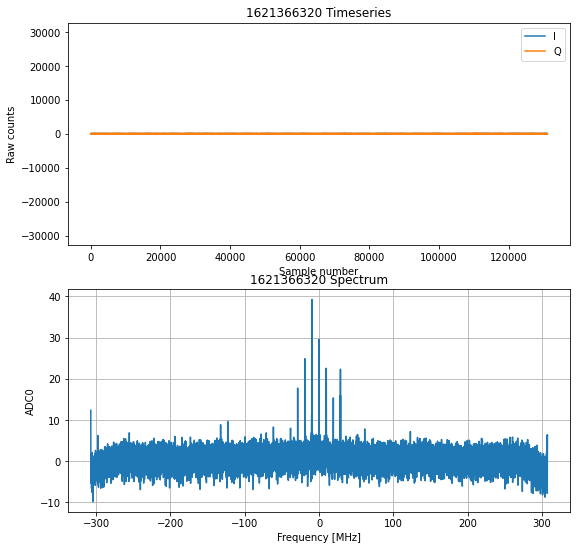

In [8]:
adc_data = S.read_adc_data(data_length=2**16, band=0, make_plot=True, show_plot=True)

### Play a single tone
Let's play a single tone and look at DAC and ADC

In [9]:
S.set_amplitude_scale_channel(0, 2, 12)

/usr/local/src/pysmurf/python/pysmurf/client/util/smurf_util.py:1723: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(f_plot, 10*np.log10(p_dac))


(-20.0, 90.0)

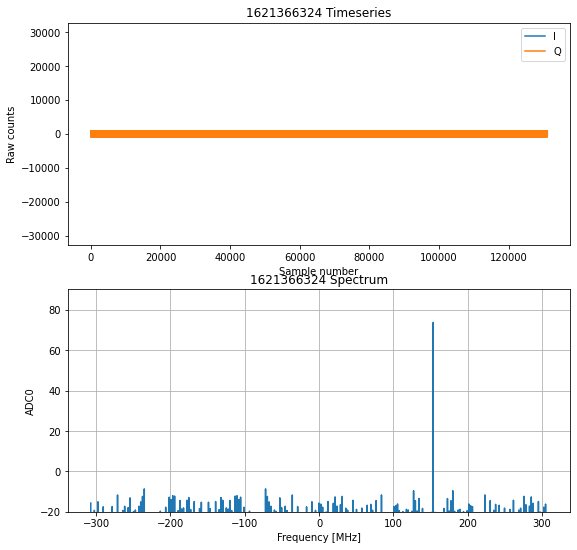

In [10]:
dac_data = S.read_dac_data(data_length=2**16, band=0, make_plot=True, show_plot=True)
plt.ylim([-20, 90])

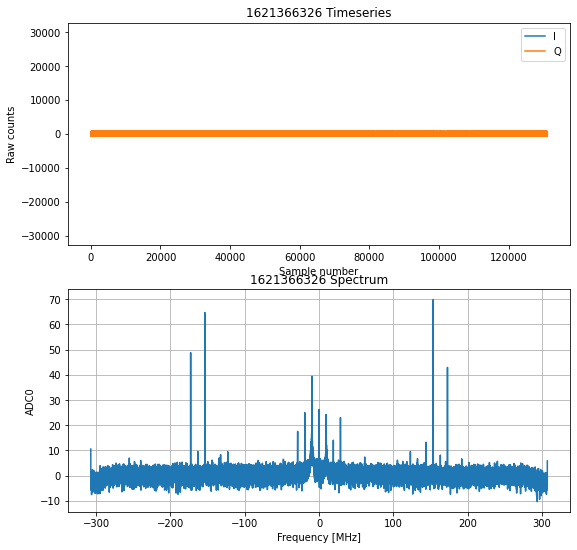

In [11]:
adc_data = S.read_adc_data(data_length=2**16, band=0, make_plot=True, show_plot=True)

We can see the x4 Rx tones -- main tone, upmix image, downmix image x2.  Let's null the upmix image

In [12]:
freqs = epics.caget(epics_prefix+':AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:toneFrequencyOffsetMHz')
j = 2
main_channel = j
channel      = np.argmin(np.abs(freqs + freqs[j] + 2*9.6))
readback_channel = channel
#channel      = np.argmin(np.abs(freqs + freqs[j]))
#readback_channel = np.argmin(np.abs(freqs + freqs[j]))
epics.caput(epics_prefix + f':AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:iqSynthesisCorrection:channelIndex[{channel}]', main_channel)
S.set_amplitude_scale_channel(0, main_channel, 14)
         
def updateCal(x):
    iCorrection = epics_prefix + f':AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:iqSynthesisCorrection:iCorrection[{channel}]'
    qCorrection = epics_prefix + f':AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:iqSynthesisCorrection:qCorrection[{channel}]'
    epics.caput(iCorrection, np.round(x[0]*2**15))
    epics.caput(qCorrection, np.round(x[1]*2**15))
    return np.abs(getResp(0, readback_channel))**2
x0 = (0, 0)
bnds = ((-0.3, 0.3), (-0.3, 0.3))
res = minimize(updateCal, x0, method='Powell', bounds=bnds, tol=1e-6)
print(f'Channel {main_channel} cal is: ' + str(res.x))
updateCal(res.x)

Channel 2 cal is: [0.03908517 0.09187461]


3.10865880237543e-08

/usr/local/src/pysmurf/python/pysmurf/client/util/smurf_util.py:1723: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(f_plot, 10*np.log10(p_dac))


(-20.0, 90.0)

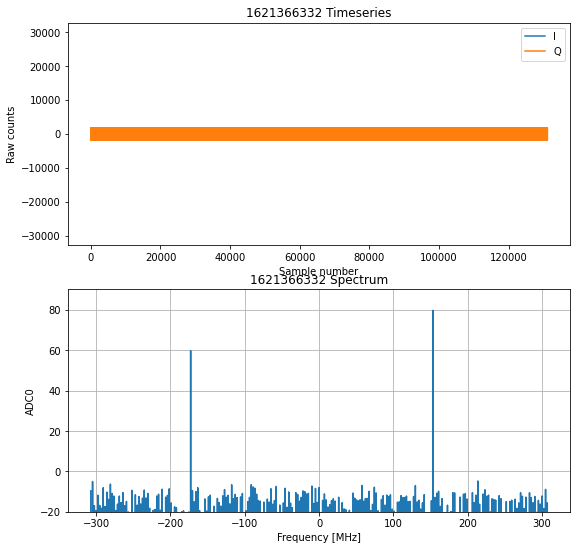

In [13]:
dac_data = S.read_dac_data(data_length=2**16, band=0, make_plot=True, show_plot=True)
plt.ylim([-20, 90])

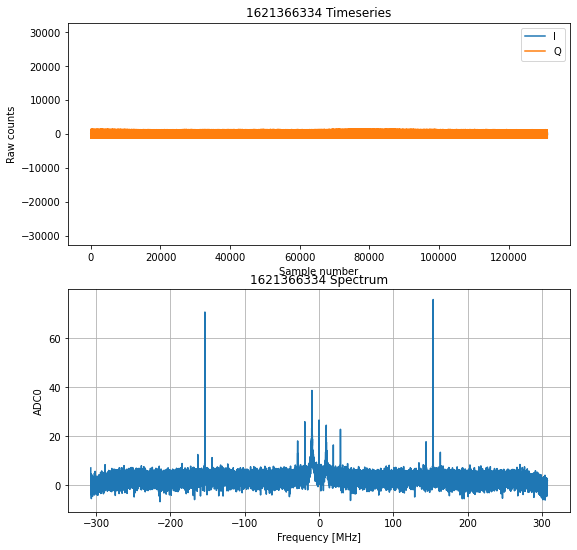

In [14]:
adc_data = S.read_adc_data(data_length=2**16, band=0, make_plot=True, show_plot=True)